<a href="https://colab.research.google.com/github/HoarfrostRaven/Apprentissages-Automatiques-Appliques/blob/main/IMDB_Dataset_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')

Data source import complete.


In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

There is 1 csv file in the current version of the dataset:


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown=1, nGraphPerRow=1):
    # For displaying purposes, pick columns that have between 1 and 50 unique values
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]

    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')

    nGraphShown = min(nRow, nGraphShown)
    for i in range(nGraphShown):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 45)
        plt.title(f'{columnNames[i]}')

    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

Now you're ready to read in the data and use the plotting functions to visualize the data.

In [5]:
nRowsRead = None # specify 'None' if want to read whole file
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'IMDB Dataset.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 50000 rows and 2 columns


Let's take a quick look at what the data looks like:

In [6]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Distribution graphs (histogram/bar graph) of sampled columns:

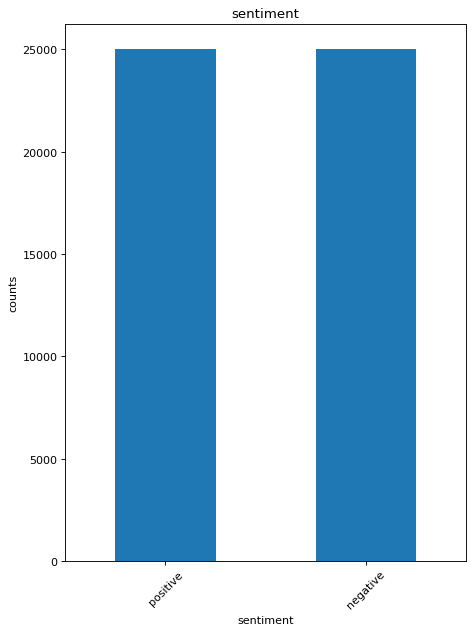

In [7]:
plotPerColumnDistribution(df)

## Transform Data

In [8]:
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# 定义函数对每条影评进行预处理（转换为小写，并拆分成单词）
def tokenize(text):
    # 先转换为小写
    text = text.lower()
    # 用正则表达式拆分单词（保留字母和数字）
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

In [10]:
def word_frequency_encoding(df, vocab_size=20000):
    """
    对df中的'review'列进行词频编码，返回带有'vectorized_review'列的df，以及词典 word_to_id

    参数:
        df: 包含'review'和'sentiment'两列的DataFrame
        vocab_size: 保留的最常见的单词数（默认20000）

    返回:
        df: 增加'vectorized_review'列后的DataFrame
        word_to_id: 单词到编号的映射字典
    """

    # 1. 统计词频
    all_tokens = []
    for review in df['review']:
        tokens = tokenize(review)
        all_tokens.extend(tokens)

    word_counts = Counter(all_tokens)

    # 2. 排序并保留最常用的 vocab_size 个词
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    most_common_words = sorted_words[:vocab_size]

    # 3. 构建词典（保留特殊符号）
    word_to_id = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, _) in enumerate(most_common_words, start=2):
        word_to_id[word] = idx

    # 4. 编码函数
    def vectorize_review(review):
        tokens = tokenize(review)
        return [word_to_id.get(token, word_to_id['<UNK>']) for token in tokens]

    # 5. 对所有影评进行编码
    df = df.copy()  # 避免修改原始df
    df['vectorized_review'] = df['review'].apply(vectorize_review)

    return df, word_to_id

In [11]:
df_encoded, vocab_dict = word_frequency_encoding(df)

In [12]:
print(f"词典大小: {len(vocab_dict)}")
print(df_encoded[['review', 'vectorized_review']].head(1))

词典大小: 20002
                                              review  \
0  One of the other reviewers has mentioned that ...   

                                   vectorized_review  
0  [30, 5, 2, 79, 2063, 48, 1064, 13, 102, 151, 4...  


In [13]:
# 将 sentiment 列转换为 0/1
df_encoded['label'] = df_encoded['sentiment'].map({'negative': 0, 'positive': 1})

# 计算每条评论的长度
df_encoded['review_length'] = df_encoded['vectorized_review'].apply(len)

In [23]:
df_encoded.head(5)

,review,sentiment,vectorized_review,label,review_length
0,One of the other reviewers has mentioned that ...,positive,"[30, 5, 2, 79, 2063, 48, 1064, 13, 102, 151, 4...",1,320
1,A wonderful little production. <br /><br />The...,positive,"[4, 396, 122, 356, 8, 8, 2, 1381, 2982, 7, 55,...",1,166
2,I thought this was a wonderful way to spend ti...,positive,"[11, 194, 12, 15, 4, 396, 97, 6, 1152, 59, 24,...",1,172
3,Basically there's a family where a little boy ...,negative,"[683, 41, 14, 4, 229, 117, 4, 122, 403, 3364, ...",0,141
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[1, 10635, 14, 112, 10, 2, 59, 5, 293, 7, 4, 2...",1,236


In [17]:
# 打印基本统计信息
print(df_encoded['review_length'].describe())

count    50000.000000
mean       239.537900
std        177.383495
min          6.000000
25%        131.000000
50%        179.000000
75%        291.000000
max       2525.000000
Name: review_length, dtype: float64


In [19]:
# 获取特征和标签
# 将所有序列统一填充/截断到 200 长度，超过的部分截断，不足的部分在尾部填充0（对应 <PAD>）
X_padded = pad_sequences(df_encoded['vectorized_review'].tolist(), maxlen=200,
                         padding='post', truncating='post', value=0)
y = df_encoded['label'].values

# 划分测试集（20% 做测试）
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# 保存训练+验证集
np.savez('processed_imdb_train_data.npz', X=X_train, y=y_train)

# 保存测试集
np.savez('processed_imdb_test_data.npz', X=X_test, y=y_test)

print("数据已保存为 processed_imdb_train_data.npz 和 processed_imdb_test_data.npz")

填充后数据形状: (50000, 200)
